In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import warnings
warnings.filterwarnings('ignore')



In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
try:
    from ucimlrepo import fetch_ucirepo 
    
    # fetch dataset by ID
    adult = fetch_ucirepo(id=2) 
    
    # data 
    X = adult.data.features 
    y = adult.data.targets
    
    # concat
    df = pd.concat([X, y], axis=1)
    print(f" Shape: {df.shape}")
    
except Exception as e:
    print(f"UCI ID not found: {e}")
    

 Shape: (48842, 15)


## EXPLORATORY DATA ANALYSIS

In [4]:
print(f"Shape: {df.shape}")
print(f"Number of features: {df.shape[1]-1}")
print(f"Number of samples: {df.shape[0]}")

#前5行
print("\nFirst 5 rows:")
print(df.head())

#dtype
print(f"\nData types:")
print(df.dtypes)

#describe
print(f"\nDescriptive Statistics for Numerical Features:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
print(df[numerical_cols].describe())

#missing values
print(f"\nMissing Values Check:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

#'?'
print(f"\nChecking for '?' markers:")
question_mark_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':
        count = (df[col] == '?').sum()
        if count > 0:
            question_mark_counts[col] = count

if question_mark_counts:
    for col, count in question_mark_counts.items():
        print(f"{col}: {count} '?' values")
else:
    print("No '?' markers found")

#distribution
print(f"\nTarget Variable Distribution:")
#clean targeted var
df['income'] = df['income'].str.strip().str.replace('.', '')
income_distribution = df['income'].value_counts()
print(income_distribution)
print(f"\nTarget proportions:")
print(df['income'].value_counts(normalize=True))


Shape: (48842, 15)
Number of features: 14
Number of samples: 48842

First 5 rows:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0 

## Visualize

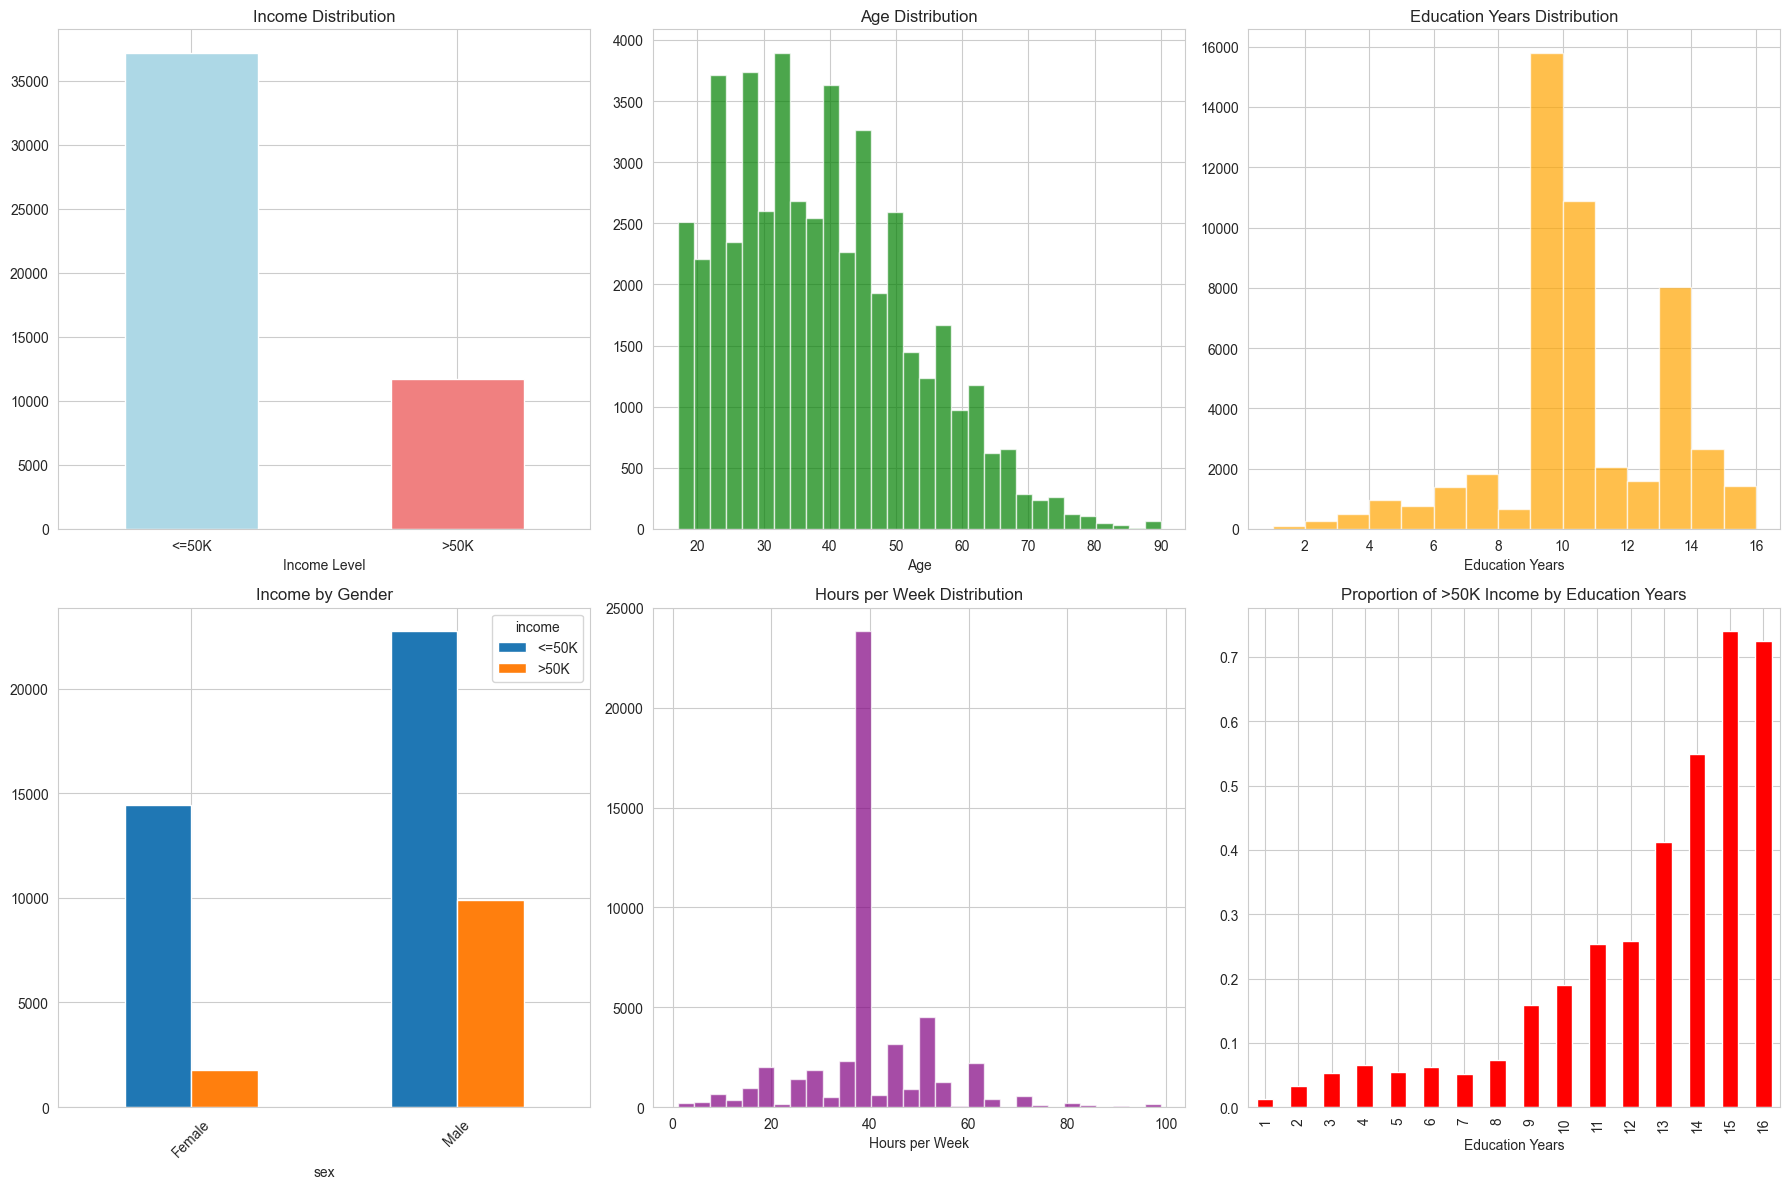

In [5]:
#创建子图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

#income
df['income'].value_counts().plot(kind='bar', ax=axes[0,0], color=['lightblue', 'lightcoral'])
axes[0,0].set_title('Income Distribution')
axes[0,0].set_xlabel('Income Level')
axes[0,0].tick_params(axis='x', rotation=0)

#age
axes[0,1].hist(df['age'], bins=30, alpha=0.7, color='green')
axes[0,1].set_title('Age Distribution')
axes[0,1].set_xlabel('Age')

#edu num
axes[0,2].hist(df['education-num'], bins=15, alpha=0.7, color='orange')
axes[0,2].set_title('Education Years Distribution')
axes[0,2].set_xlabel('Education Years')

#gender w/ income
gender_income_crosstab = pd.crosstab(df['sex'], df['income'])
gender_income_crosstab.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Income by Gender')
axes[1,0].tick_params(axis='x', rotation=45)

#working hours
axes[1,1].hist(df['hours-per-week'], bins=30, alpha=0.7, color='purple')
axes[1,1].set_title('Hours per Week Distribution')
axes[1,1].set_xlabel('Hours per Week')

#edu num w/ income
education_income = pd.crosstab(df['education-num'], df['income'], normalize='index')
if '>50K' in education_income.columns:
    education_income['>50K'].plot(kind='bar', ax=axes[1,2], color='red')
    axes[1,2].set_title('Proportion of >50K Income by Education Years')
    axes[1,2].set_xlabel('Education Years')

plt.tight_layout()
plt.savefig('data_exploration_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## Preprocessing

In [7]:
#1. Missing Values
#?-> NaN
df_clean = df.replace('?', np.nan)

# 显示缺失值统计
missing_stats = df_clean.isnull().sum()
print(missing_stats[missing_stats > 0])

#delete missing value col
rows_before = len(df_clean)
df_clean = df_clean.dropna()
rows_after = len(df_clean)
print(f"Rows removed: {rows_before - rows_after}")
print(f"Final dataset shape: {df_clean.shape}")

#2. Separating Features and Target
X = df_clean.drop('income', axis=1)
y = df_clean['income']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target classes: {y.unique()}")

#3. Encoding Categorical Features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

#对分类特征进行标签编码
X_encoded = X.copy()
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    X_encoded[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le
    print(f"  {feature}: {len(le.classes_)} unique categories")

#编码目标变量
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)
print(f"\nTarget encoding: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# 检查类别分布
print(f"Training set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} ({count/len(y_train)*100:.1f}%)")

# 5. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

# 检查标准化效果
print(f"Before scaling - mean range: [{X_train.mean().min():.2f}, {X_train.mean().max():.2f}]")
print(f"After scaling - mean range: [{X_train_scaled.mean(axis=0).min():.2f}, {X_train_scaled.mean(axis=0).max():.2f}]")

workclass         2799
occupation        2809
native-country     857
dtype: int64
Rows removed: 3620
Final dataset shape: (45222, 15)
Features shape: (45222, 14)
Target shape: (45222,)
Target classes: ['<=50K' '>50K']
Categorical features (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numerical features (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
  workclass: 7 unique categories
  education: 16 unique categories
  marital-status: 7 unique categories
  occupation: 14 unique categories
  relationship: 6 unique categories
  race: 5 unique categories
  sex: 2 unique categories
  native-country: 41 unique categories

Target encoding: {'<=50K': np.int64(0), '>50K': np.int64(1)}
Training set: (36177, 14)
Test set: (9045, 14)
Training set class distribution:
  Class 0: 27211 (75.2%)
  Class 1: 8966 (24.8%)
Scaled training set shape: (36177, 14)
Scaled test set shape: (9045, 14)
Befor

## Model Training

In [8]:
# 初始化模型字典
models = {}
training_times = {}

#reg
print("Training Logistic Regression...")
start_time = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)
lr_time = time.time() - start_time
models['Logistic Regression'] = lr_model
training_times['Logistic Regression'] = lr_time
print(f"  Completed in {lr_time:.2f} seconds")

#K近邻
print("Training K-Nearest Neighbors...")
start_time = time.time()
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train_scaled, y_train)
knn_time = time.time() - start_time
models['KNN'] = knn_model
training_times['KNN'] = knn_time
print(f"  Completed in {knn_time:.2f} seconds")

#ds tree
print("Training Decision Tree...")
start_time = time.time()
dt_model = DecisionTreeClassifier(
    random_state=42, 
    max_depth=15, 
    min_samples_split=20,
    min_samples_leaf=10
)
dt_model.fit(X_train_scaled, y_train)
dt_time = time.time() - start_time
models['Decision Tree'] = dt_model
training_times['Decision Tree'] = dt_time
print(f"  Completed in {dt_time:.2f} seconds")

#Vector Machine
print("Training Support Vector Machine...")
start_time = time.time()
svm_model = SVC(random_state=42, kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train)
svm_time = time.time() - start_time
models['SVM'] = svm_model
training_times['SVM'] = svm_time
print(f"  Completed in {svm_time:.2f} seconds")

Training Logistic Regression...
  Completed in 0.02 seconds
Training K-Nearest Neighbors...
  Completed in 0.01 seconds
Training Decision Tree...
  Completed in 0.09 seconds
Training Support Vector Machine...
  Completed in 5.75 seconds


## Evaluate models

In [9]:
# 
results = {}
all_predictions = {}

# for loop evaluate
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}:")
    
    # 预测
    y_pred = model.predict(X_test_scaled)
    all_predictions[model_name] = y_pred
    
    # index
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    #save results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Training Time': training_times[model_name]
    }
    
    #
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

#df for performance
results_df = pd.DataFrame(results).T
print(f"\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(results_df.round(4))

#find best
best_accuracy = results_df['Accuracy'].max()
best_model = results_df['Accuracy'].idxmax()
fastest_model = results_df['Training Time'].idxmin()

print(f"\nBest performing model: {best_model} (Accuracy: {best_accuracy:.4f})")
print(f"Fastest training model: {fastest_model} (Time: {results_df.loc[fastest_model, 'Training Time']:.2f}s)")



Evaluating Logistic Regression:
  Accuracy:  0.8200
  Precision: 0.8089
  Recall:    0.8200
  F1-Score:  0.8047

Evaluating KNN:
  Accuracy:  0.8253
  Precision: 0.8197
  Recall:    0.8253
  F1-Score:  0.8217

Evaluating Decision Tree:
  Accuracy:  0.8450
  Precision: 0.8381
  Recall:    0.8450
  F1-Score:  0.8388

Evaluating SVM:
  Accuracy:  0.8409
  Precision: 0.8331
  Recall:    0.8409
  F1-Score:  0.8321

MODEL PERFORMANCE SUMMARY
                     Accuracy  Precision  Recall  F1-Score  Training Time
Logistic Regression    0.8200     0.8089  0.8200    0.8047         0.0233
KNN                    0.8253     0.8197  0.8253    0.8217         0.0120
Decision Tree          0.8450     0.8381  0.8450    0.8388         0.0871
SVM                    0.8409     0.8331  0.8409    0.8321         5.7467

Best performing model: Decision Tree (Accuracy: 0.8450)
Fastest training model: KNN (Time: 0.01s)


## Confusion matrix

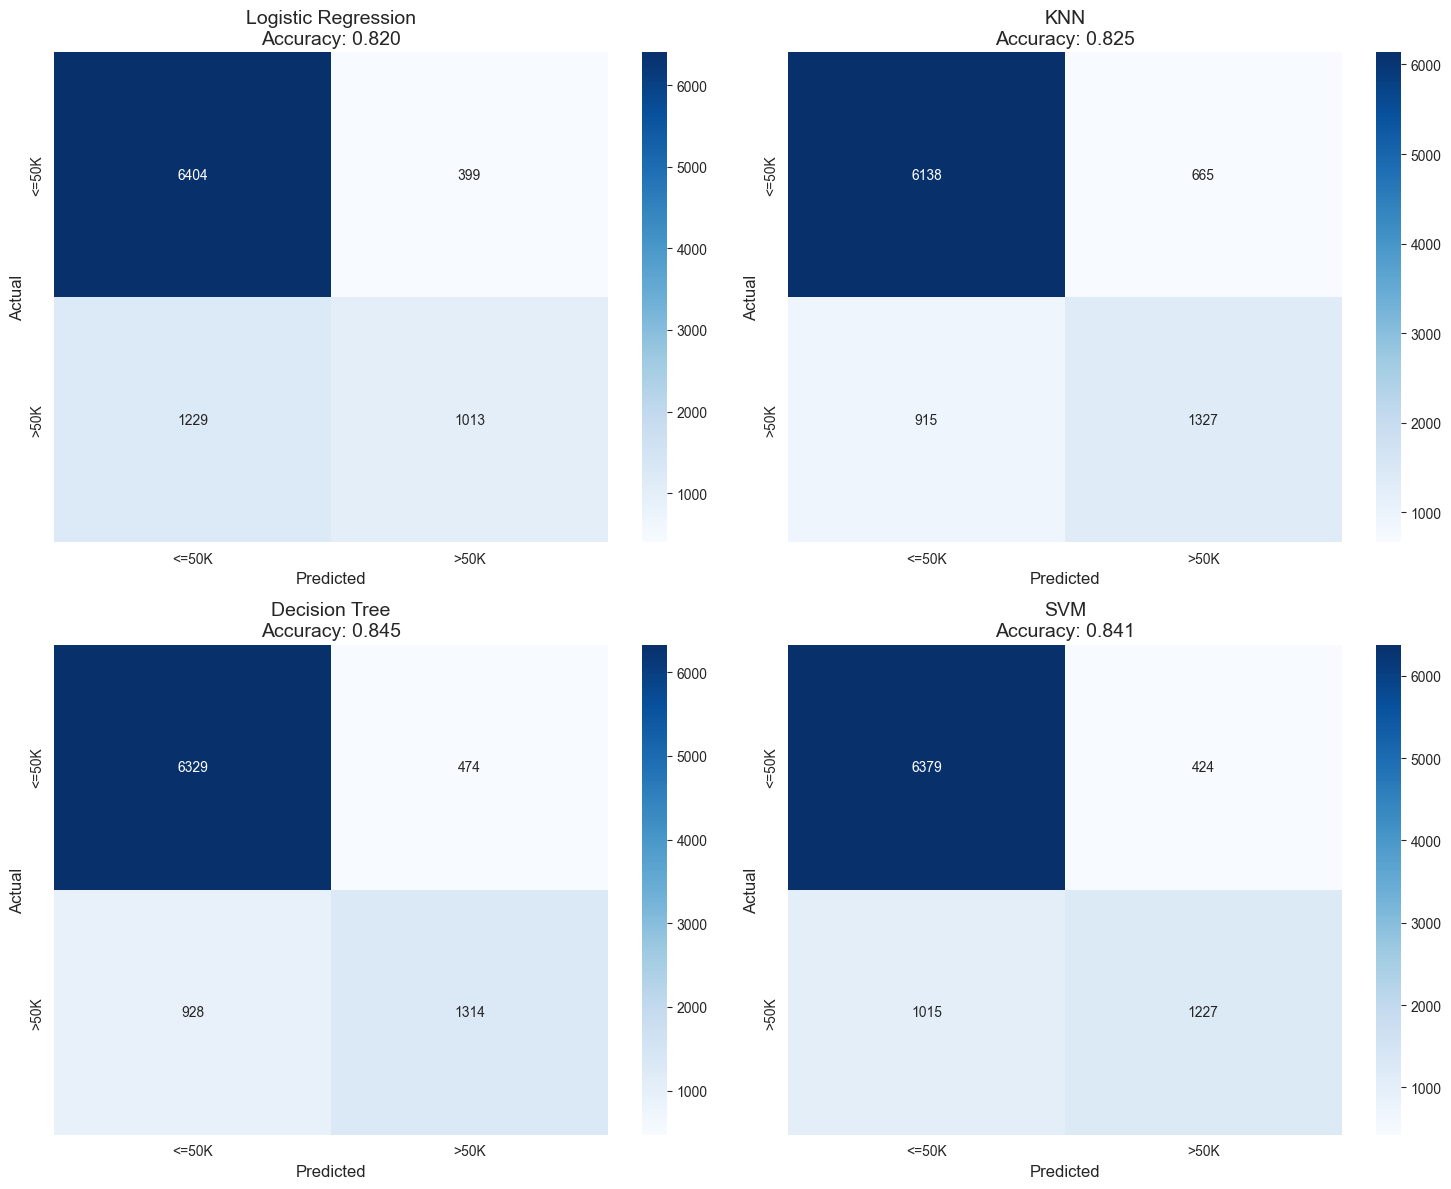

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (model_name, model) in enumerate(models.items()):
    y_pred = all_predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)
    
    #
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues',
                xticklabels=['<=50K', '>50K'], 
                yticklabels=['<=50K', '>50K'])
    
    accuracy = results[model_name]['Accuracy']
    axes[i].set_title(f'{model_name}\nAccuracy: {accuracy:.3f}', fontsize=14)
    axes[i].set_xlabel('Predicted', fontsize=12)
    axes[i].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## Performance plots

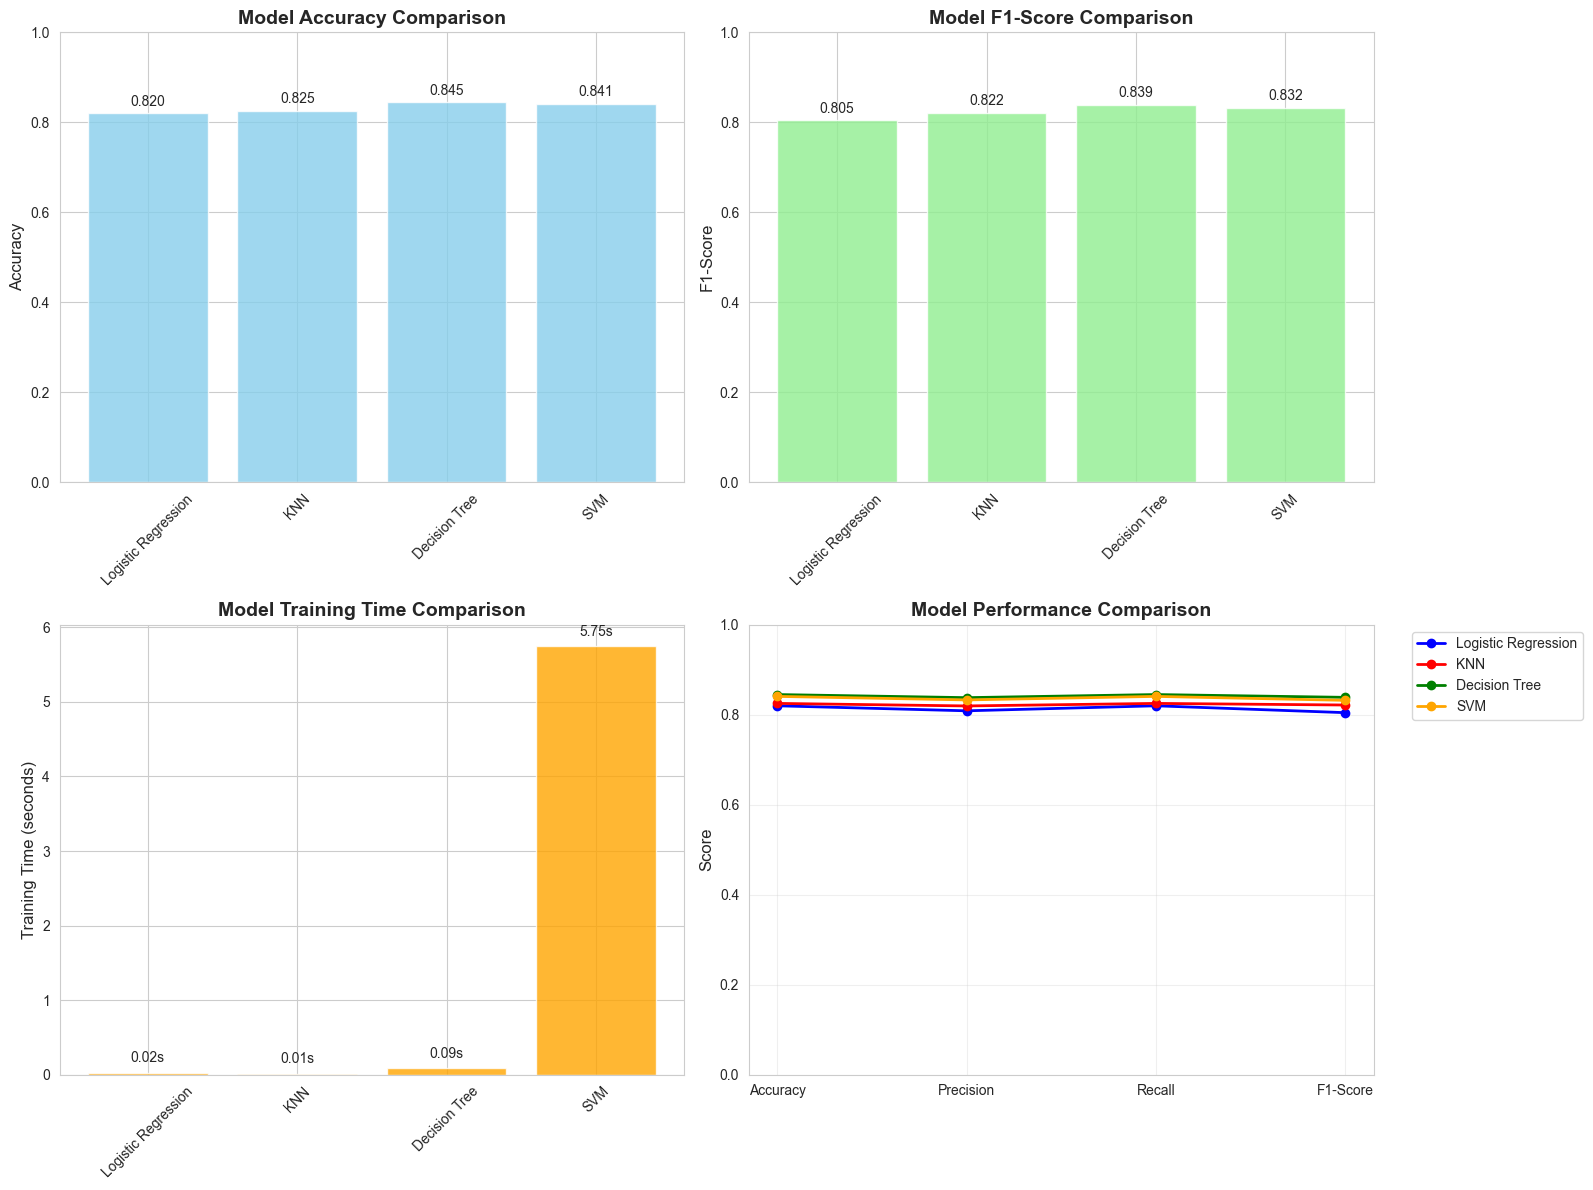

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#accuracy
ax1 = axes[0, 0]
bars1 = ax1.bar(results_df.index, results_df['Accuracy'], color='skyblue', alpha=0.8)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)
#tag
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

#F1 score comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(results_df.index, results_df['F1-Score'], color='lightgreen', alpha=0.8)
ax2.set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=12)
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

#trained time
ax3 = axes[1, 0]
bars3 = ax3.bar(results_df.index, results_df['Training Time'], color='orange', alpha=0.8)
ax3.set_title('Model Training Time Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Training Time (seconds)', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}s', ha='center', va='bottom', fontsize=10)

#ax4
ax4 = axes[1, 1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'red', 'green', 'orange']

for i, model_name in enumerate(results_df.index):
    values = [results_df.loc[model_name, metric] for metric in metrics]
    ax4.plot(metrics, values, marker='o', linewidth=2, 
             label=model_name, color=colors[i], markersize=6)

ax4.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score', fontsize=12)
ax4.set_ylim(0, 1)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Feature Importance

Top 10 most important features (by absolute coefficient):
       Feature  Coefficient
  capital-gain     2.406161
 education-num     0.854902
           age     0.477197
           sex     0.436414
hours-per-week     0.343284
marital-status    -0.334746
  capital-loss     0.273392
  relationship    -0.220484
     workclass    -0.127686
          race     0.091195
Top 10 most important features (by importance score):
       Feature  Importance
  relationship    0.353053
 education-num    0.193093
  capital-gain    0.181517
           age    0.064466
  capital-loss    0.051991
        fnlwgt    0.049547
hours-per-week    0.044622
    occupation    0.035643
     workclass    0.012234
native-country    0.003673


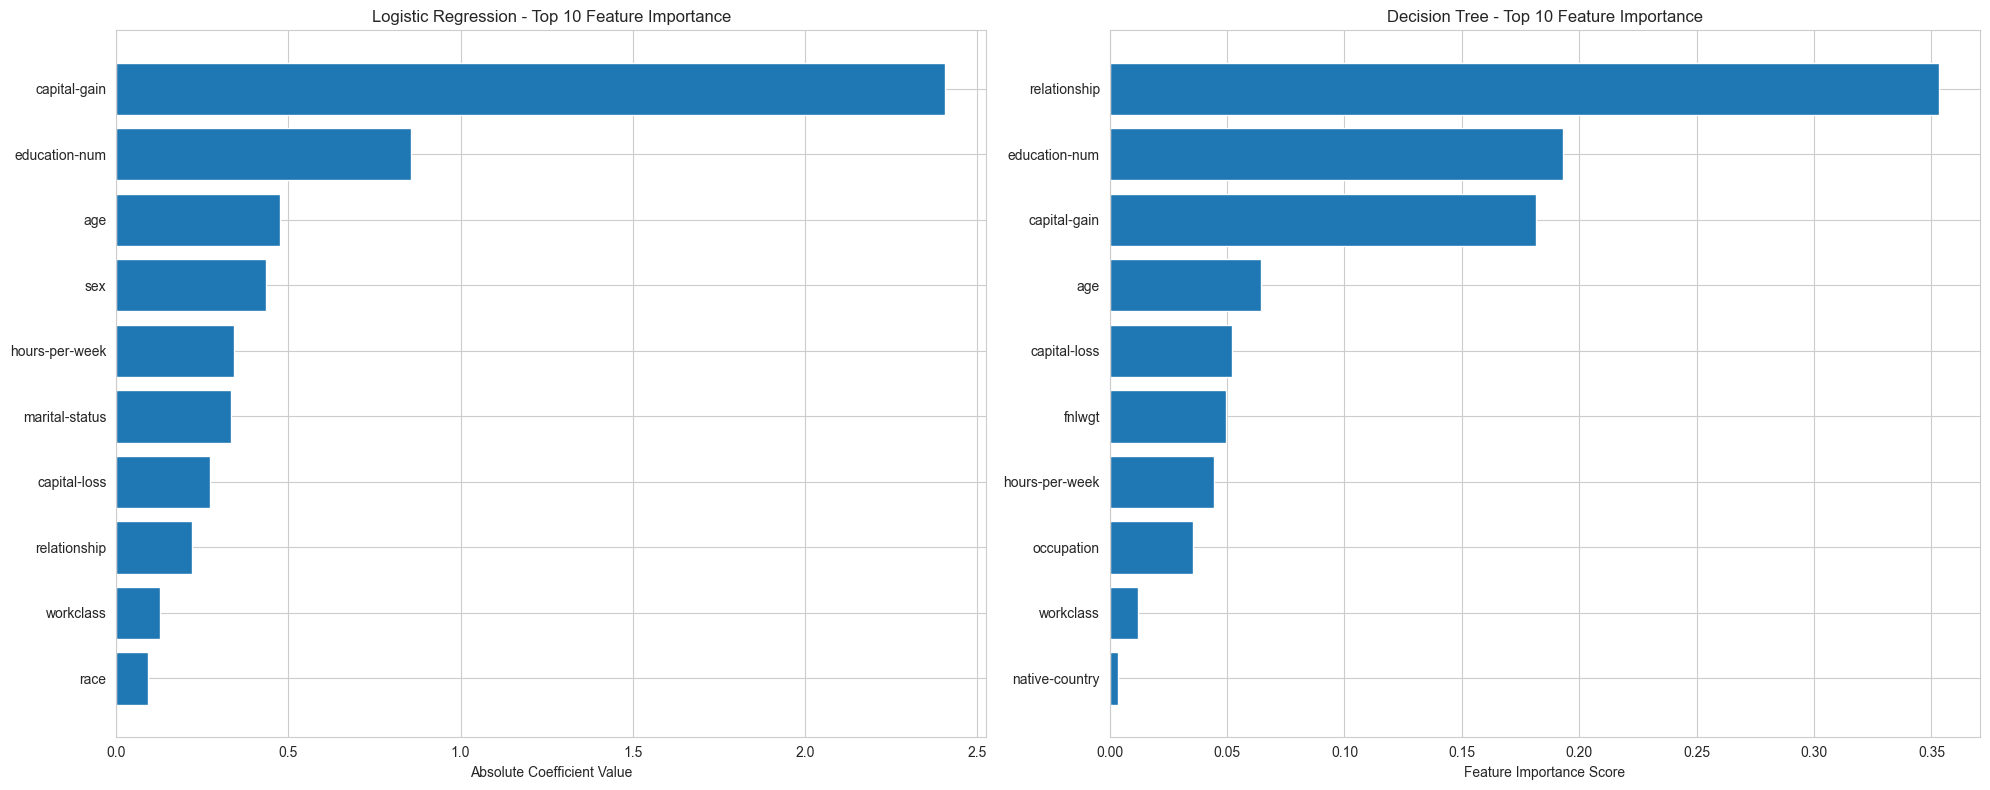

In [ ]:
feature_names = X_encoded.columns.tolist()

# 特征重要性图
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

#1.Logistic Regression Feature Coefficients
lr_coef = models['Logistic Regression'].coef_[0]
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef,
    'Abs_Coefficient': np.abs(lr_coef)
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 10 most important features (by absolute coefficient):")
print(coef_df.head(10)[['Feature', 'Coefficient']].to_string(index=False))

# abs Coefficient
top_10_lr = coef_df.head(10)
axes[0].barh(range(len(top_10_lr)), top_10_lr['Abs_Coefficient'])
axes[0].set_yticks(range(len(top_10_lr)))
axes[0].set_yticklabels(top_10_lr['Feature'])
axes[0].set_xlabel('Absolute Coefficient Value')
axes[0].set_title('Logistic Regression - Top 10 Feature Importance')
axes[0].invert_yaxis()

# 2. Decision Tree Feature Importance
dt_importance = models['Decision Tree'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_importance
}).sort_values('Importance', ascending=False)

print("Top 10 most important features (by importance score):")
print(importance_df.head(10).to_string(index=False))

# 决策树特征重要性
top_10_dt = importance_df.head(10)
axes[1].barh(range(len(top_10_dt)), top_10_dt['Importance'])
axes[1].set_yticks(range(len(top_10_dt)))
axes[1].set_yticklabels(top_10_dt['Feature'])
axes[1].set_xlabel('Feature Importance Score')
axes[1].set_title('Decision Tree - Top 10 Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Classification report

In [13]:
target_names = ['<=50K', '>50K']

for model_name, model in models.items():
    print(f"\n{model_name} Classification Report:")
    print("-" * 50)
    y_pred = all_predictions[model_name]
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)


Logistic Regression Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      6803
        >50K       0.72      0.45      0.55      2242

    accuracy                           0.82      9045
   macro avg       0.78      0.70      0.72      9045
weighted avg       0.81      0.82      0.80      9045


KNN Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.89      6803
        >50K       0.67      0.59      0.63      2242

    accuracy                           0.83      9045
   macro avg       0.77      0.75      0.76      9045
weighted avg       0.82      0.83      0.82      9045


Decision Tree Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87     